## SVM
Support Vector Machines (SVM) are classical machine learning algorithms designed to find a decision boundary (or hyperplane) that best separates classes by maximizing the margin between the classes.

In [3]:
#############################################
# Chunk 1: Imports, Seeds, and Setup
#############################################
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

#############################################
# Chunk 2: Data Collection and Label Encoding
#############################################
def get_image_paths_and_labels(directory):
    file_paths = []
    labels = []
    # List subdirectories (each class) in sorted order for consistency
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        for file in os.listdir(cls_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(cls_dir, file))
                labels.append(cls)
    return pd.DataFrame({'file_path': file_paths, 'label': labels})

# Define the copied training directory (adjust path if needed)
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
df = get_image_paths_and_labels(new_train_dir)
print("Sample image paths and labels:")
print(df.head())

# Encode labels into numerical values
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

Sample image paths and labels:
                                           file_path      label
0  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
1  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
2  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
3  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
4  intel_dataset_copy/seg_train/seg_train/buildin...  buildings


In [4]:
#############################################
# Chunk 3: Feature Extraction using MobileNetV2
#############################################
# Load MobileNetV2 pre-trained on ImageNet without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
# Create a feature extractor using Global Average Pooling
gap = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=gap)

def extract_features(file_path, target_size=(150,150)):
    img = load_img(file_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = feature_extractor.predict(img_array, verbose=0)
    return features.flatten()

# Extract features for all images (you can sample a subset for speed if needed)
features = []
for path in tqdm(df['file_path'], desc="Extracting features"):
    feat = extract_features(path)
    features.append(feat)
features = np.array(features)
print("Extracted features shape:", features.shape)

#############################################
# Chunk 4: Feature Scaling
#############################################
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2851/3103120432.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
Extracting features: 100%|████████████████████████████████████| 14016/14016 [13:19<00:00, 17.53it/s]


Extracted features shape: (14016, 1280)


In [5]:
#############################################
# Chunk 5: K-Fold Splitting and SVM Training
#############################################
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
folds = list(skf.split(features_scaled, df['label_encoded']))
print(f"Total folds: {len(folds)}")

fold_f1_scores = []
fold_reports = []
best_svm_fold1 = None  # To store the SVM model from fold 1
X_test_fold1, y_test_fold1 = None, None

fold = 1
for train_idx, test_idx in folds:
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = features_scaled[train_idx], features_scaled[test_idx]
    y_train, y_test = df['label_encoded'].values[train_idx], df['label_encoded'].values[test_idx]
    
    # Define SVM classifier with hyperparameter tuning via GridSearchCV
    svm_model = SVC(random_state=42)
    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    grid = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print("Best parameters for fold", fold, ":", grid.best_params_)
    
    y_pred = grid.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Fold", fold, "Weighted F1 Score:", f1)
    fold_f1_scores.append(f1)
    
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print("Fold", fold, "Classification Report:\n", report)
    fold_reports.append(report)
    
    # For demonstration, store the model from fold 1 for later evaluation on image predictions
    if fold == 1:
        best_svm_fold1 = grid
        X_test_fold1, y_test_fold1 = X_test, y_test
    
    fold += 1

avg_f1 = np.mean(fold_f1_scores)
print("\nAverage Weighted F1 Score across folds:", avg_f1)

Total folds: 5

--- Fold 1 ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for fold 1 : {'C': 1, 'kernel': 'rbf'}
Fold 1 Weighted F1 Score: 0.923899646805015
Fold 1 Classification Report:
               precision    recall  f1-score   support

   buildings       0.93      0.94      0.94       438
      forest       0.99      0.97      0.98       454
     glacier       0.87      0.86      0.86       481
    mountain       0.89      0.87      0.88       501
         sea       0.93      0.97      0.95       454
      street       0.93      0.94      0.94       476

    accuracy                           0.92      2804
   macro avg       0.93      0.93      0.93      2804
weighted avg       0.92      0.92      0.92      2804


--- Fold 2 ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for fold 2 : {'C': 1, 'kernel': 'rbf'}
Fold 2 Weighted F1 Score: 0.9124952738050324
Fold 2 Classification Report:
               precision    re

Evaluating the model based on an aggregate of all folds from SVM

[CV] END ...............................C=0.1, kernel=linear; total time=  57.2s
[CV] END ..................................C=0.1, kernel=rbf; total time= 2.9min
[CV] END ................................C=10, kernel=linear; total time=  52.9s
[CV] END ...................................C=10, kernel=rbf; total time= 1.5min
[CV] END ...............................C=0.1, kernel=linear; total time=  53.6s
[CV] END .................................C=1, kernel=linear; total time=  54.2s
[CV] END .................................C=1, kernel=linear; total time=  52.1s
[CV] END ....................................C=1, kernel=rbf; total time= 2.0min
[CV] END ...................................C=10, kernel=rbf; total time= 1.8min
[CV] END ..................................C=0.1, kernel=rbf; total time= 3.2min
[CV] END ....................................C=1, kernel=rbf; total time= 2.1min
[CV] END ...............................C=0.1, kernel=linear; total time= 1.0min
[CV] END ...................

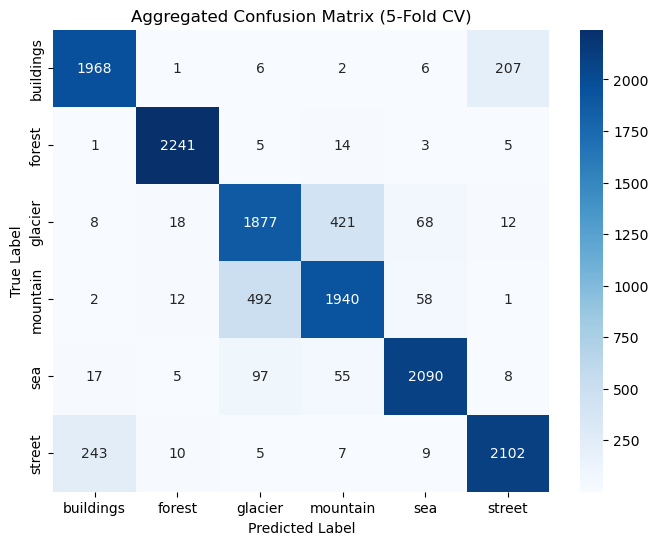

Aggregated Classification Report:
              precision    recall  f1-score   support

   buildings       0.88      0.90      0.89      2190
      forest       0.98      0.99      0.98      2269
     glacier       0.76      0.78      0.77      2404
    mountain       0.80      0.77      0.78      2505
         sea       0.94      0.92      0.93      2272
      street       0.90      0.88      0.89      2376

    accuracy                           0.87     14016
   macro avg       0.87      0.87      0.87     14016
weighted avg       0.87      0.87      0.87     14016

Aggregated Weighted F1 Score: 0.8718055193535389


In [7]:
#############################################
# Part 1: Aggregated Evaluation using Cross-Validation Predictions
#############################################
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

# Use SVM (with a linear kernel) for aggregated predictions via cross_val_predict
svm_model_cv = SVC(kernel='linear', probability=True, random_state=42)
all_y_pred = cross_val_predict(svm_model_cv, features_scaled, df['label_encoded'], cv=5)
all_y_true = df['label_encoded'].values

# Compute and plot the aggregated confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Aggregated Confusion Matrix (5-Fold CV)')
plt.show()

# Print the aggregated classification report and weighted F1 score
print("Aggregated Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=le.classes_))
print("Aggregated Weighted F1 Score:", f1_score(all_y_true, all_y_pred, average='weighted'))

Creating the visualization from the predictions from the SVM model

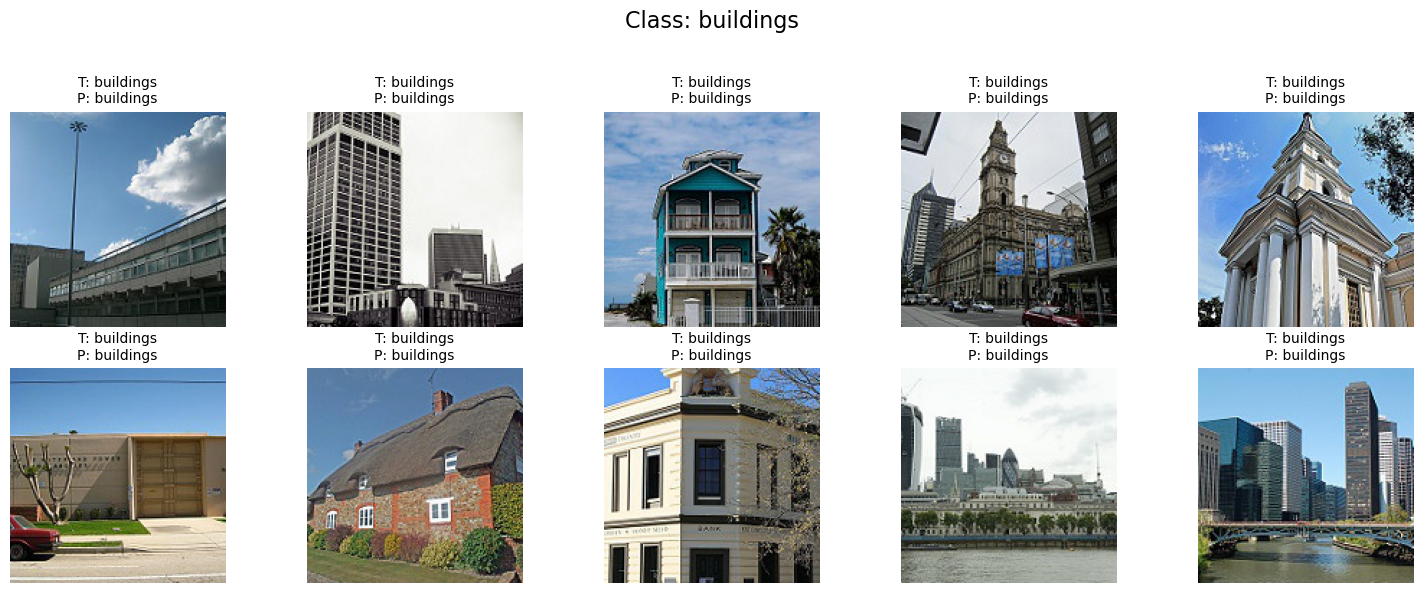

--------------------------------------------------------------------------------


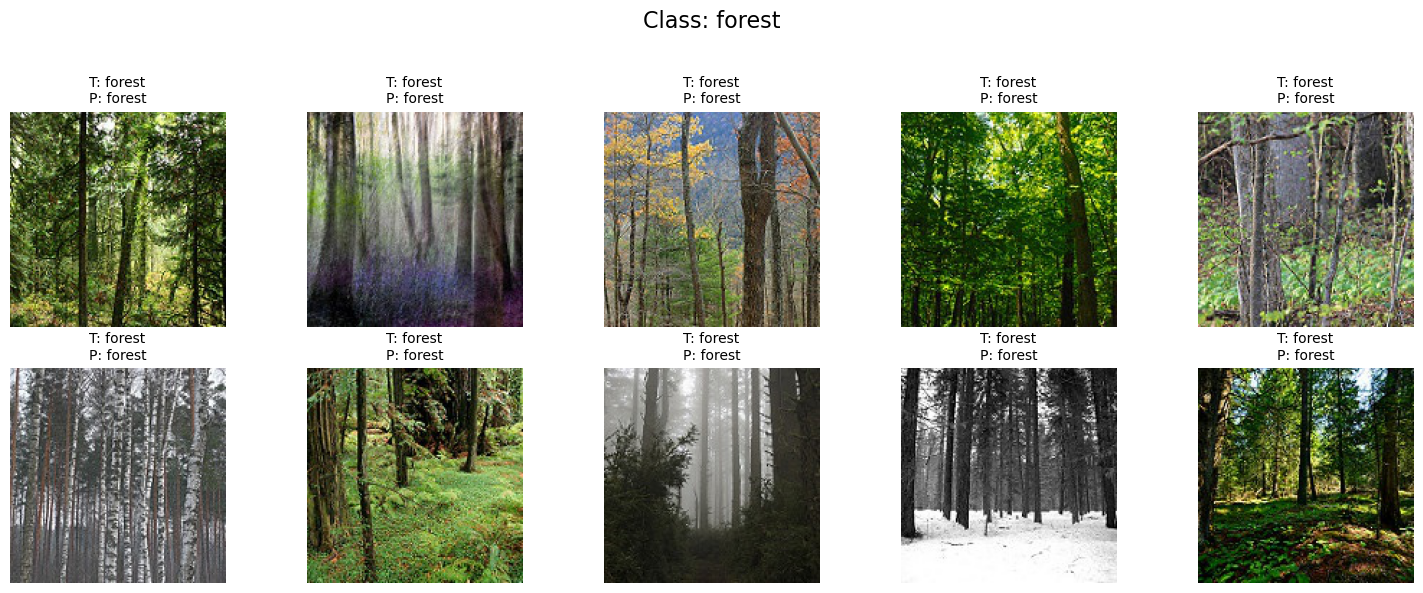

--------------------------------------------------------------------------------


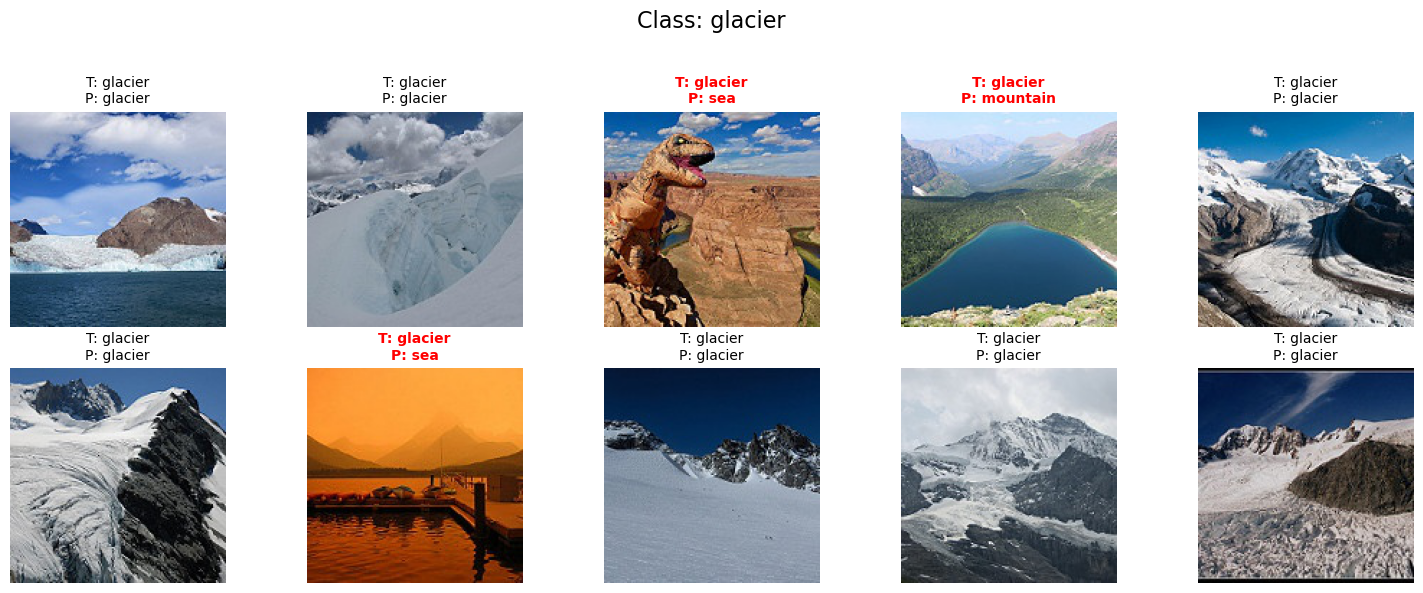

--------------------------------------------------------------------------------


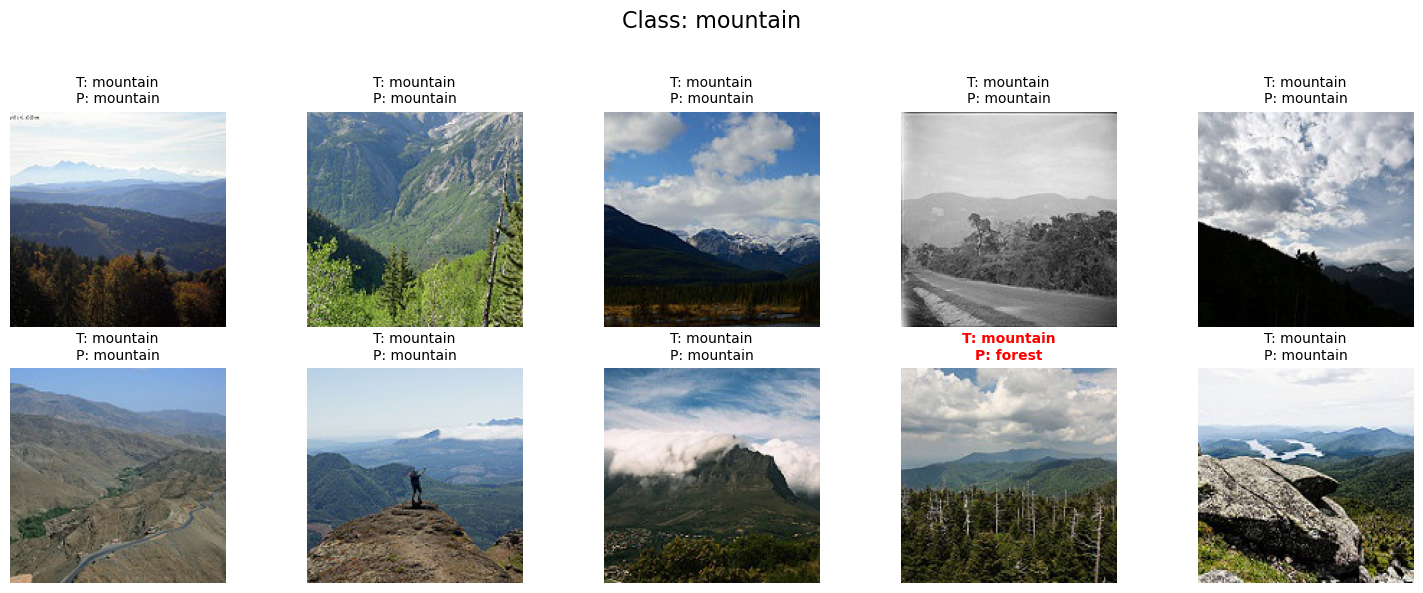

--------------------------------------------------------------------------------


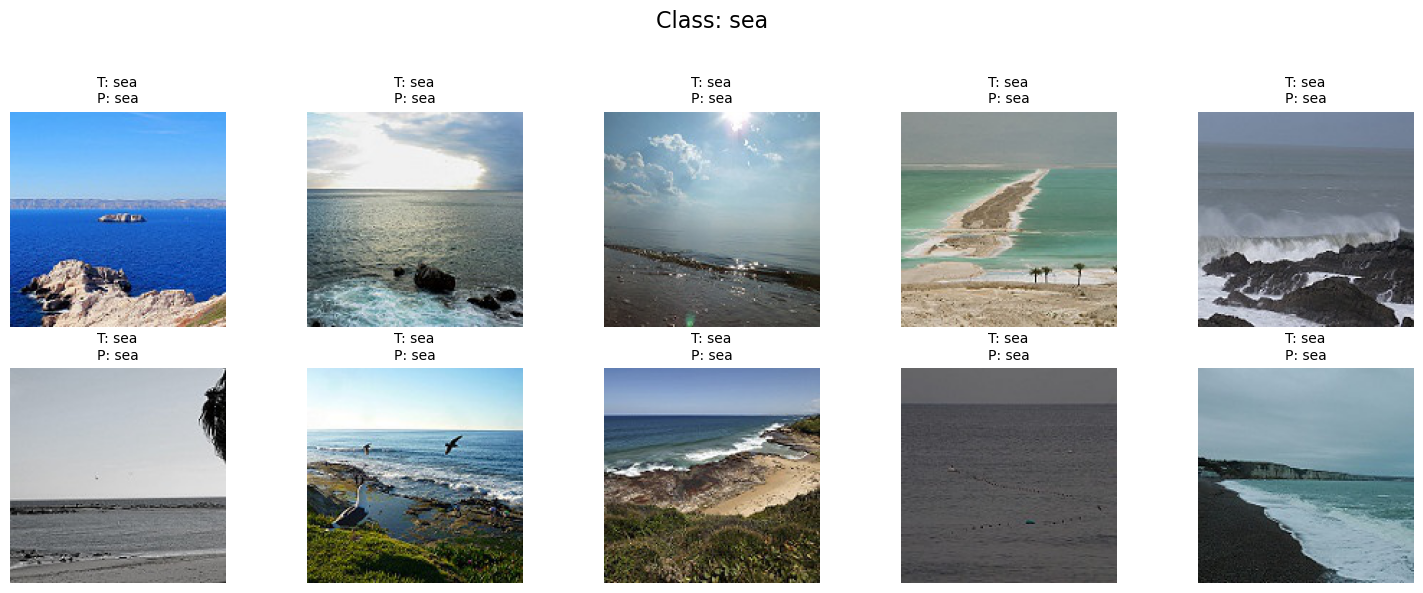

--------------------------------------------------------------------------------


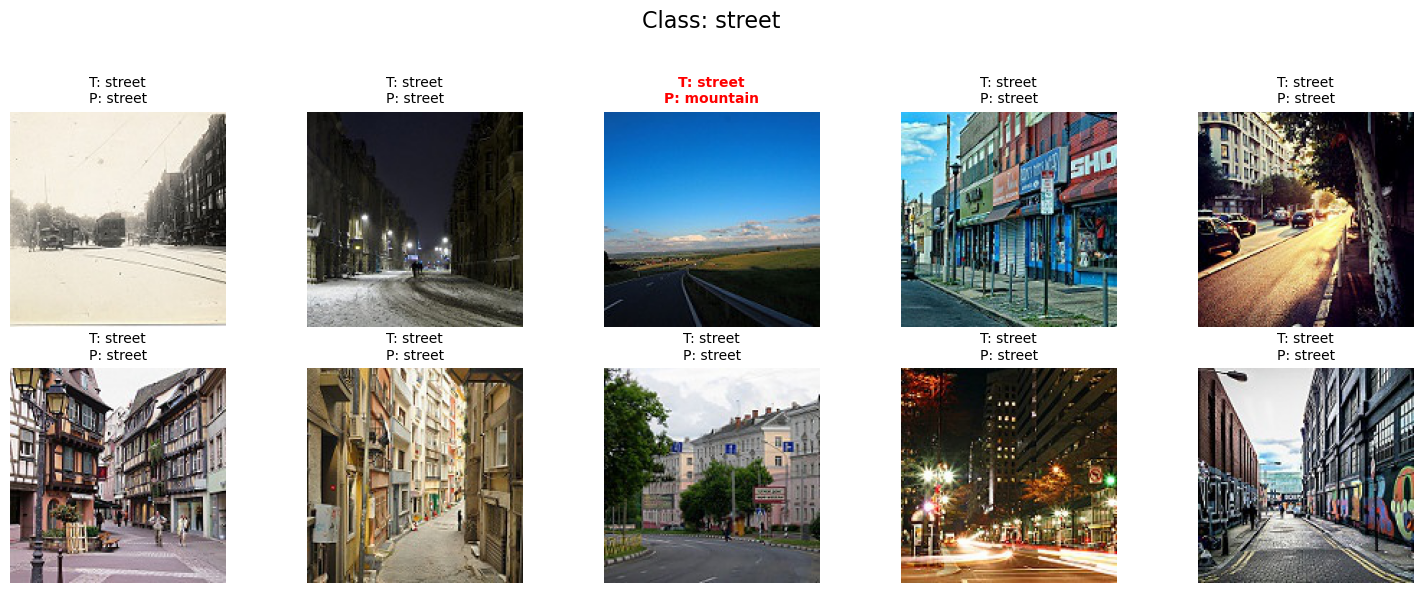

--------------------------------------------------------------------------------


In [9]:
#############################################
# Part 2: Visualization of Predictions on Test Set Images
#############################################
from tensorflow.keras.preprocessing.image import load_img

def display_svm_predictions(num_images=10, rows=2, cols=5, target_size=(150,150)):
    # Set random seed for reproducibility
    random.seed(42)
    
    # Define the copied test directory
    new_test_dir = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')
    # Get sorted list of classes in the test set
    classes = sorted([d for d in os.listdir(new_test_dir) if os.path.isdir(os.path.join(new_test_dir, d))])
    
    for cls in classes:
        class_dir = os.path.join(new_test_dir, cls)
        # Get a sorted list of image files
        images = sorted([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        # Randomly select up to num_images images
        selected = random.sample(images, min(num_images, len(images)))
        
        # Create subplots: grid of 2 rows x 5 columns for the current class
        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        fig.suptitle(f"Class: {cls}", fontsize=16)
        axes = axes.flatten()
        
        for ax, img_file in zip(axes, selected):
            img_path = os.path.join(class_dir, img_file)
            # Load the image (resized for display)
            img = load_img(img_path, target_size=target_size)
            # Extract features and scale them using your feature extractor and scaler
            feat = extract_features(img_path, target_size=target_size)
            feat_scaled = scaler.transform(feat.reshape(1, -1))
            # Predict using the SVM model from fold 1 (stored as best_svm_fold1)
            pred_encoded = best_svm_fold1.predict(feat_scaled)[0]
            pred_class = le.inverse_transform([pred_encoded])[0]
            true_class = cls
            
            title_text = f"T: {true_class}\nP: {pred_class}"
            # Highlight false predictions in bold red
            if pred_class != true_class:
                ax.set_title(title_text, fontweight='bold', color='red', fontsize=10)
            else:
                ax.set_title(title_text, fontsize=10)
            ax.imshow(img)
            ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        print("-" * 80)

# Call the function to display predictions: 10 images per class (2 rows x 5 columns)
display_svm_predictions(num_images=10, rows=2, cols=5, target_size=(150,150))